In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import random

from models.mnist_model import Generator, Discriminator, DHead, QHead
from dataloader import get_data
from utils import *
from config import params

if(params['dataset'] == 'MNIST'):
    from models.mnist_model import Generator, Discriminator, DHead, QHead
elif(params['dataset'] == 'SVHN'):
    from models.svhn_model import Generator, Discriminator, DHead, QHead
elif(params['dataset'] == 'CelebA'):
    from models.celeba_model import Generator, Discriminator, DHead, QHead
elif(params['dataset'] == 'FashionMNIST'):
    from models.mnist_model import Generator, Discriminator, DHead, QHead


In [2]:

# Set random seed for reproducibility.
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

# Use GPU if available.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

dataloader = get_data(params['dataset'], params['batch_size'])

# Set appropriate hyperparameters depending on the dataset used.
# The values given in the InfoGAN paper are used.
# num_z : dimension of incompressible noise.
# num_dis_c : number of discrete latent code used.
# dis_c_dim : dimension of discrete latent code.
# num_con_c : number of continuous latent code used.
if(params['dataset'] == 'MNIST'):
    params['num_z'] = 62
    params['num_dis_c'] = 1
    params['dis_c_dim'] = 10
    params['num_con_c'] = 2
elif(params['dataset'] == 'SVHN'):
    params['num_z'] = 124
    params['num_dis_c'] = 4
    params['dis_c_dim'] = 10
    params['num_con_c'] = 4
elif(params['dataset'] == 'CelebA'):
    params['num_z'] = 128
    params['num_dis_c'] = 10
    params['dis_c_dim'] = 10
    params['num_con_c'] = 0
elif(params['dataset'] == 'FashionMNIST'):
    params['num_z'] = 62
    params['num_dis_c'] = 1
    params['dis_c_dim'] = 10
    params['num_con_c'] = 2

# Plot the training images.
sample_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 100], nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.savefig('Training Images {}'.format(params['dataset']))
plt.close('all')


Random Seed:  1123
cuda:0  will be used.



In [3]:

# Initialise the network.
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

netD = DHead().to(device)
netD.apply(weights_init)
print(netD)

netQ = QHead().to(device)
netQ.apply(weights_init)
print(netQ)

# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()

# Adam optimiser is used.
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))
optimG = optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))

# Fixed Noise
z = torch.randn(100, params['num_z'], 1, 1, device=device)
fixed_noise = z
if(params['num_dis_c'] != 0):
    idx = np.arange(params['dis_c_dim']).repeat(10)
    dis_c = torch.zeros(100, params['num_dis_c'], params['dis_c_dim'], device=device)
    for i in range(params['num_dis_c']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

if(params['num_con_c'] != 0):
    con_c = torch.rand(100, params['num_con_c'], 1, 1, device=device) * 2 - 1
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

real_label = 1
fake_label = 0

# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []




Generator(
  (tconv1): ConvTranspose2d(168, 448, kernel_size=(2, 2), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(448, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), str

In [4]:
print("-"*25)
print("Starting Training Loop...\n")
print('Epochs: %d\nDataset: {}\nBatch Size: %d\nLength of Data Loader: %d'.format(params['dataset']) % (params['num_epochs'], params['batch_size'], len(dataloader)))
print("-"*25)

start_time = time.time()
iters = 0

for epoch in range(params['num_epochs']):
    epoch_start_time = time.time()

    for i, (data, _) in enumerate(dataloader, 0):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)

        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device,dtype=torch.float32)
        output1 = discriminator(real_data)
        # print(output1.dtype)
        # with torch.no_grad():
        #     print(netD(output1).dtype)
        probs_real = netD(output1).view(-1)
        # print(label.dtype,probs_real.dtype)
        loss_real = criterionD(probs_real, label)
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        label.fill_(fake_label)
        noise, idx = noise_sample(params['num_dis_c'], params['dis_c_dim'], params['num_con_c'], params['num_z'], b_size, device)
        fake_data = netG(noise)
        output2 = discriminator(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label)
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator
        D_loss = loss_real + loss_fake
        # Update parameters
        optimD.step()

        # Updating Generator and QHead
        optimG.zero_grad()

        # Fake data treated as real.
        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label)

        q_logits, q_mu, q_var = netQ(output)
        target = torch.LongTensor(idx).to(device)
        # Calculating loss for discrete latent code.
        dis_loss = 0
        for j in range(params['num_dis_c']):
            dis_loss += criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j])

        # Calculating loss for continuous latent code.
        con_loss = 0
        if (params['num_con_c'] != 0):
            con_loss = criterionQ_con(noise[:, params['num_z']+ params['num_dis_c']*params['dis_c_dim'] : ].view(-1, params['num_con_c']), q_mu, q_var)*0.1

        # Net loss for generator.
        G_loss = gen_loss + dis_loss + con_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        optimG.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, params['num_epochs'], i, len(dataloader), 
                    D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) == params['num_epochs']/2):
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("Epoch_%d {}".format(params['dataset']) %(epoch+1))
        plt.close('all')

    # Save network weights.
    if (epoch+1) % params['save_epoch'] == 0:
        torch.save({
            'netG' : netG.state_dict(),
            'discriminator' : discriminator.state_dict(),
            'netD' : netD.state_dict(),
            'netQ' : netQ.state_dict(),
            'optimD' : optimD.state_dict(),
            'optimG' : optimG.state_dict(),
            'params' : params
            }, 'checkpoint/model_epoch_%d_{}'.format(params['dataset']) %(epoch+1))

training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)

-------------------------
Starting Training Loop...

Epochs: 500
Dataset: SVHN
Batch Size: 128
Length of Data Loader: 125
-------------------------
[1/500][100/125]	Loss_D: 1.2432	Loss_G: 15.9265
Time taken for Epoch 1: 51.15s
[2/500][100/125]	Loss_D: 0.4450	Loss_G: 12.5193
Time taken for Epoch 2: 41.66s
[3/500][100/125]	Loss_D: 0.3652	Loss_G: 12.9256
Time taken for Epoch 3: 35.78s
[4/500][100/125]	Loss_D: 0.5330	Loss_G: 11.4800
Time taken for Epoch 4: 27.31s
[5/500][100/125]	Loss_D: 0.5184	Loss_G: 10.6507
Time taken for Epoch 5: 26.22s
[6/500][100/125]	Loss_D: 0.5305	Loss_G: 9.9955
Time taken for Epoch 6: 29.57s
[7/500][100/125]	Loss_D: 0.4098	Loss_G: 9.4301
Time taken for Epoch 7: 27.48s
[8/500][100/125]	Loss_D: 0.6284	Loss_G: 9.3855
Time taken for Epoch 8: 26.41s
[9/500][100/125]	Loss_D: 0.4652	Loss_G: 8.7335
Time taken for Epoch 9: 24.84s
[10/500][100/125]	Loss_D: 0.4902	Loss_G: 6.8886
Time taken for Epoch 10: 24.38s
[11/500][100/125]	Loss_D: 0.9269	Loss_G: 8.1350
Time taken for Ep

MovieWriter imagemagick unavailable; using Pillow instead.


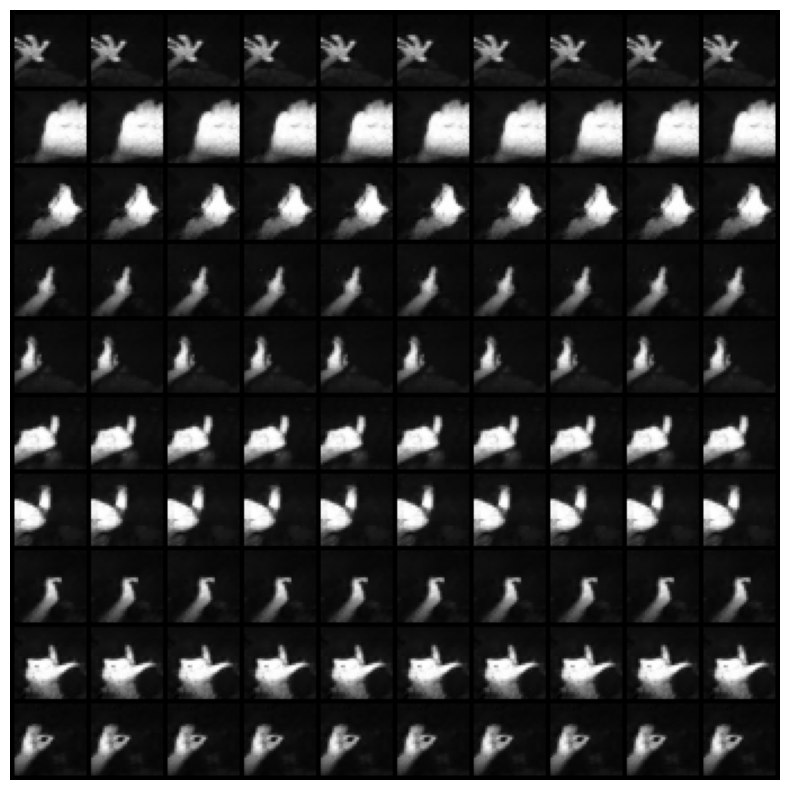

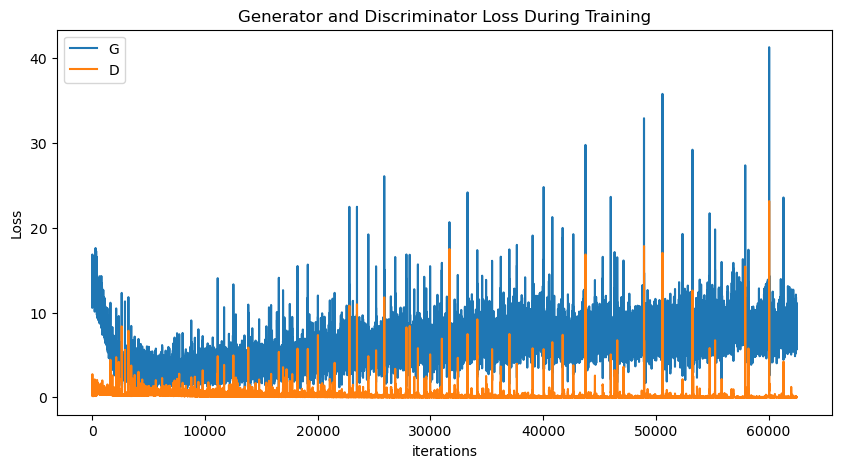

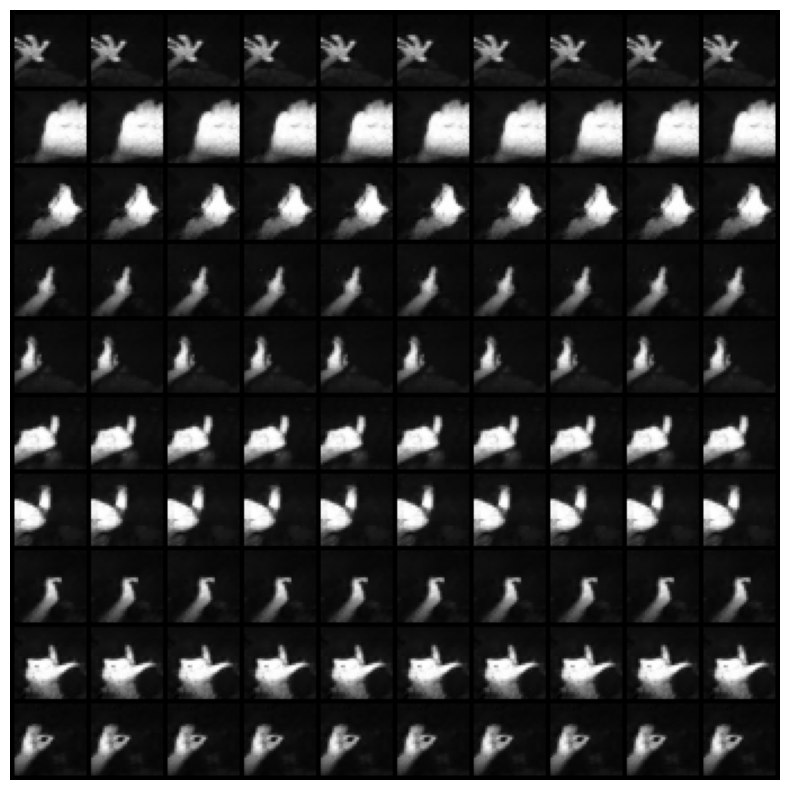

In [5]:

# Generate image to check performance of trained generator.
with torch.no_grad():
    gen_data = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.savefig("Epoch_%d_{}".format(params['dataset']) %(params['num_epochs']))

# Save network weights.
torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    'params' : params
    }, 'checkpoint/model_final_{}'.format(params['dataset']))


# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss Curve {}".format(params['dataset']))

# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('infoGAN_{}.gif'.format(params['dataset']), dpi=80, writer='imagemagick')
plt.show()

Generator(
  (tconv1): ConvTranspose2d(168, 448, kernel_size=(2, 2), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(448, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


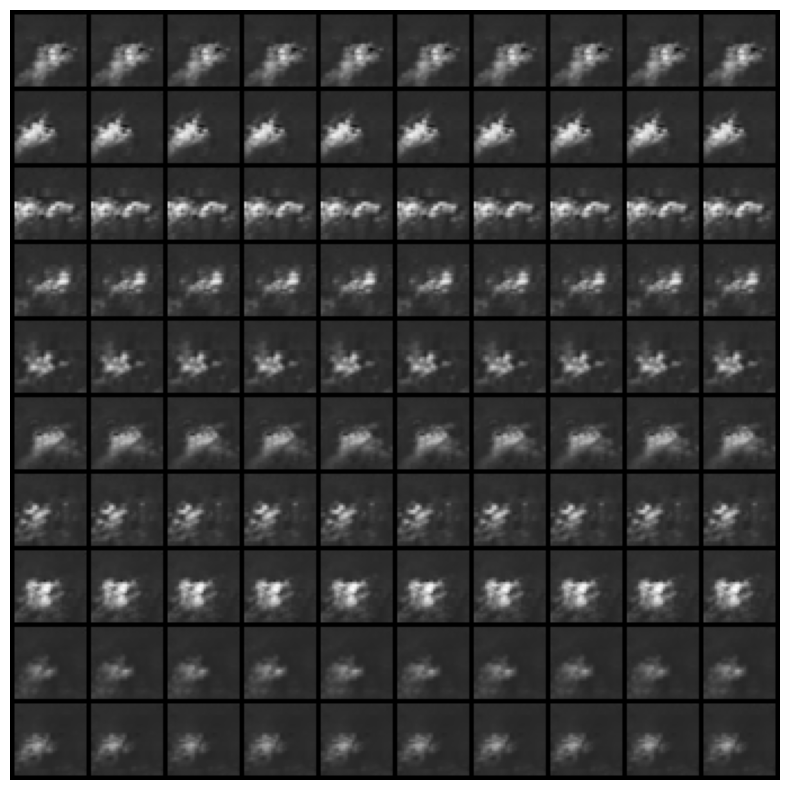

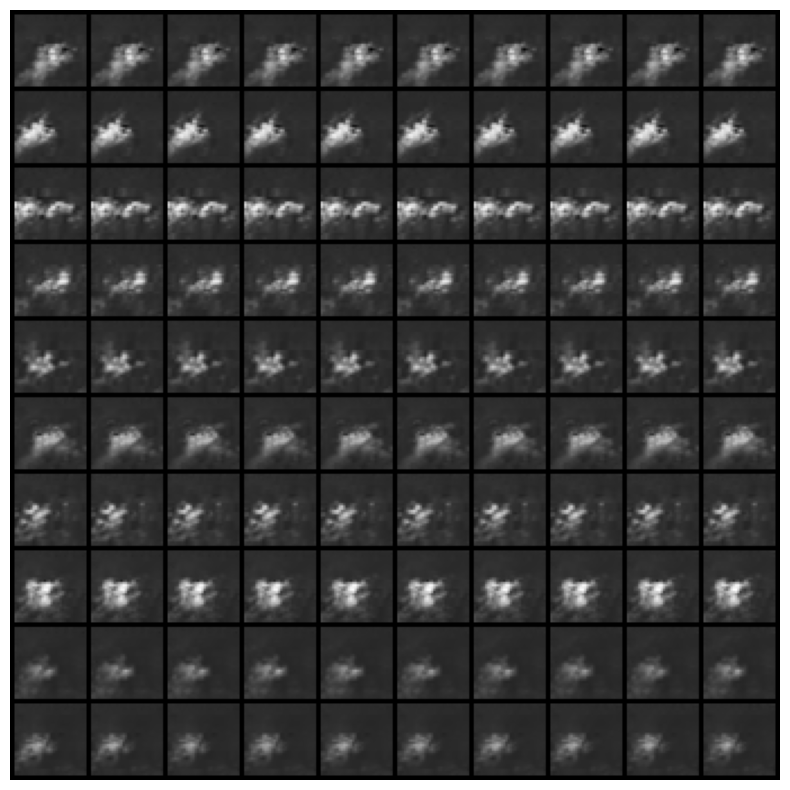

In [19]:
import argparse

import torch
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# parser = argparse.ArgumentParser()
# parser.add_argument('-load_path', required=True, help='Checkpoint to load path from')
# args = parser.parse_args()

from models.svhn_model import Generator

# Load the checkpoint file
state_dict = torch.load('checkpoint\model_final_SVHN')

# Set the device to run on: GPU or CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
# Get the 'params' dictionary from the loaded state_dict.
params = state_dict['params']

# Create the generator network.
netG = Generator().to(device)
# Load the trained generator weights.
netG.load_state_dict(state_dict['netG'])
print(netG)

c = np.linspace(-3, 3, 10).reshape(1, -1)
c = np.repeat(c, 10, 0).reshape(-1, 1)
c = torch.from_numpy(c).float().to(device)
c = c.view(-1, 1, 1, 1)

zeros = torch.zeros(100, 1, 1, 1, device=device)

# Continuous latent code.
c2 = torch.cat(( c,c, c, c), dim=1)
c3 = torch.cat((zeros, c, c, zeros), dim=1)

idx = np.arange(10).repeat(10)
dis_c = torch.zeros(100, 10, 4, 1, device=device)
dis_c[torch.arange(0, 100), idx] = 1.0
# Discrete latent code.
c1 = dis_c.view(100, -1, 1, 1)

z = torch.randn(100, 124, 1, 1, device=device)

# To see variation along c2 (Horizontally) and c1 (Vertically)
noise1 = torch.cat((z, c1, c2), dim=1)
# To see variation along c3 (Horizontally) and c1 (Vertically)
noise2 = torch.cat((z, c1, c3), dim=1)

# Generate image.
with torch.no_grad():
    generated_img1 = netG(noise1).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img1, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()

# Generate image.
with torch.no_grad():
    generated_img2 = netG(noise2).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img2, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()